# Homework 3 

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [4]:
def des_or_for(image):
    """
    :param image: исходное изображение (RGB)
    :return: 1 - Пустыня, 0 - Лес
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray.ravel()], [0], None, [256], [0, 256])
    if np.argmax(hist) > len(hist)//2:
        return 1
    return 0

In [5]:
image = cv2.imread('desert_forest/test_image_00.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

It's forest


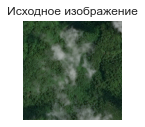

In [6]:
plt.subplot(211)
plt.imshow(image)
plt.title('Исходное изображение'), plt.axis('off')
if des_or_for(image):
    print("It's desert")
else:
    print("It's forest")

In [7]:
for i in range(10):
    imagei = cv2.imread(f'desert_forest/test_image_0{i}.jpg')
    h, w, _ = imagei.shape
    imagei = cv2.resize(imagei.copy(), (w // 2, h // 2))
    imagei = cv2.cvtColor(imagei.copy(), cv2.COLOR_BGR2RGB)
    if des_or_for(imagei):
        print(f"{i}: It's desert")
    else:
        print(f"{i}: It's forest")

for i in range(10, 17):
    imagei = cv2.imread(f'desert_forest/test_image_{i}.jpg')
    h, w, _ = imagei.shape
    imagei = cv2.resize(imagei.copy(), (w // 2, h // 2))
    imagei = cv2.cvtColor(imagei.copy(), cv2.COLOR_BGR2RGB)
    if des_or_for(imagei):
        print(f"{i}: It's desert")
    else:
        print(f"{i}: It's forest")


0: It's forest
1: It's forest
2: It's forest
3: It's forest
4: It's forest
5: It's forest
6: It's desert
7: It's forest
8: It's forest
9: It's forest
10: It's desert
11: It's desert
12: It's desert
13: It's desert
14: It's desert
15: It's desert
16: It's desert


# Задача №2 - Раздели объекты в шуме

Дано зашумленное изображение с 3 объектами: круг, треугольник и фон. Треубется выдлеить каждый объект, фон, круг и треугольник в бинарные маски. То есть треубется найти геометрическое место каждого объекта на изображении. Незашумленное изображение приведено __только__ для оценки качества решения. Запрещено использовать любую инофрмацию о незашумленном изоьражении в решении. 

Придумайте способ численной оценки качества полученного результата.

<table><tr>
    <td> <img src="segmentation/gt.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="segmentation/noise.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [8]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True
)
    cmap = 'gray' if is_gray else None
    
    plt.subplot(121)
    plt.imshow(src_image, cmap=cmap)
    plt.axis('off'), plt.title('Исходное изображение')
    
    plt.subplot(122)
    plt.imshow(transform_image, cmap=cmap)
    plt.axis('off'), plt.title('Результат преобразования')
    
    plt.show()

In [9]:
def cleaning(image):
    """
    Чистка фона
    """
    
    blur = cv2.GaussianBlur(image.copy(), (7,7), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing
    

In [10]:
def circ_or_triangle(image, mask, size = 100):
    """
    Разбиение маски (круга и треугольника) на круг и треугольник
    Смысл алгоритма:
    1) находим цвета треугольника и квадрата (максимумы на гистограмме)
    2) для каждого пикселя смотрим какие пиксели рядом и выбираем круг это или треугольник
    Примечание: алгоритм не знает круг это или треугольник, знает только фигура 1 и фигура 2 
    """
    
    h_size = size //2;
    hist = cv2.calcHist([image.ravel()], [0], None, [256], [0, 256])
    hist[0] = 0

    sorted_index_hist = np.argsort(hist.T)
    col = sorted_index_hist[0][-2:]
    
    im = np.pad(image.copy(), h_size)
    pad_mask = np.pad(mask.copy(), h_size)
    
    res1 = np.zeros(image.shape)
    res2 = np.zeros(image.shape)
    H, W = image.shape
    for y in range(0, H):
        for x in range(0, W):
            im_slice = im[y:y+size, x:x+size]
            if not pad_mask[y+h_size][x+h_size]:
                continue
                
            if np.sum(im_slice == col[0]) > np.sum(im_slice == col[1]):
                res1[y][x] = 1
            else:
                res2[y][x] = 1

    return res1, res2

In [11]:
def figures(image):
    """
    Основная функция запускающая остальные
    """
    
    hist = cv2.calcHist([image.ravel()], [0], None, [256], [0, 256])
    
    clean_mask = np.ceil(cleaning(image)/255)
    clean_image = np.uint8(image*clean_mask)
    plot_transform_result(clean_mask, clean_image, is_gray=True)
    
    fig1, fig2 = circ_or_triangle(clean_image, clean_mask)
    fig1 *= 255
    fig2 *= 255
    plot_transform_result(fig1, fig2, is_gray=True)
    

    plt.show()
    return fig1, fig2
    

(390, 530)


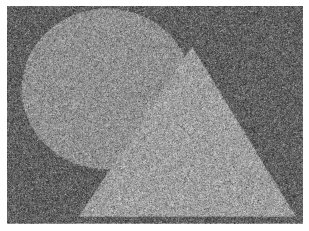

In [12]:
image = cv2.imread('segmentation/noise.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

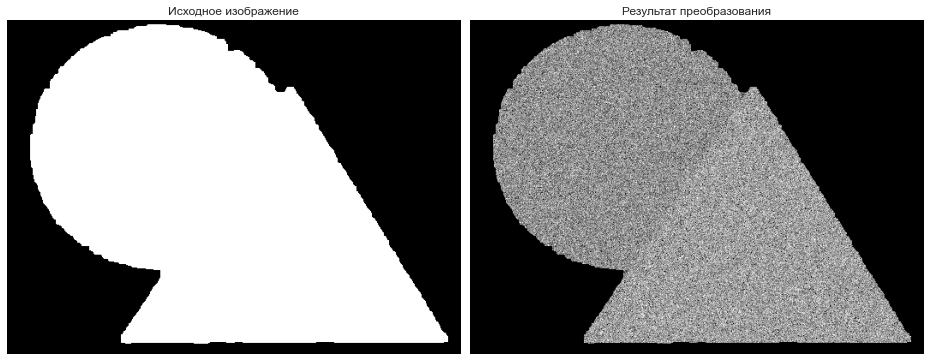

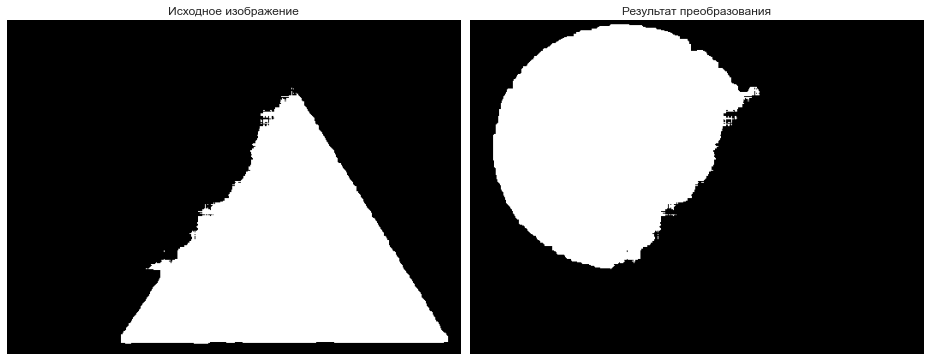

In [13]:
mask1, mask2 = figures(image)

(394, 532)


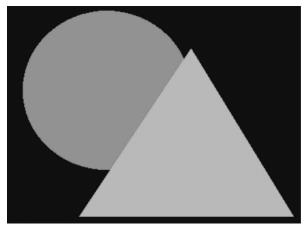

In [14]:
image_clean = cv2.imread('segmentation/gt.png')
image_clean = cv2.cvtColor(image_clean, cv2.COLOR_BGR2GRAY)
print(image_clean.shape)

plt.imshow(image_clean, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
def accuracy(clean_image, circ, triang, size_col_err = 3):
    """
    Функция проверки точности
    Так как чистая картинка имеет не 3 цвета а больше, приходиться добавлять флуктуацию цвета,
    это учитывается в size_col_err
    Не стоит считать, что точность будет 100% верная, но все же она близка к этому
    """
    
    H, W = circ.shape
    
    hist = cv2.calcHist([clean_image.ravel()], [0], None, [256], [0, 256])
    col1 = np.argmax(hist)
    hist[col1] = 0
    col2 = np.argmax(hist)
    hist[col2] = 0
    col3 = np.argmax(hist)
    hist[col3] = 0
    _, col_circ, col_triang = sorted([col1, col2, col3])
    
    
    hist = cv2.calcHist([clean_image.ravel()], [0], None, [256], [0, 256])
    count_circ = np.sum(hist[col_circ-size_col_err:col_circ+size_col_err])
    count_triang = np.sum(hist[col_triang-size_col_err:col_triang+size_col_err])
    count_all = count_circ+count_triang
    
    
    err_all = H*W
    err_circ = H*W
    err_triang = H*W
    
    for add_y in range(0, clean_image.shape[0] - circ.shape[0]+1):
        for add_x in range(0, clean_image.shape[1] - circ.shape[1]+1):
            err_circ_i = 0
            err_triang_i = 0
            for y in range(H):
                for x in range(W):
                    if abs(clean_image[y+add_y][x+add_x] - col_circ) < size_col_err  and not circ[y][x]:
                        err_circ_i += 1
                    elif abs(clean_image[y+add_y][x+add_x] - col_circ) > size_col_err and circ[y][x]:
                        err_circ_i += 1
                        
                    if abs(clean_image[y+add_y][x+add_x] - col_triang) < size_col_err and not triang[y][x]:
                        err_triang_i += 1
                    elif abs(clean_image[y+add_y][x+add_x] - col_triang) > size_col_err and triang[y][x]:
                        err_triang_i += 1
                        
            err_all_i = err_circ_i+err_triang_i
            
            if err_all_i < err_all:
                err_all, err_circ, err_triang = err_all_i, err_circ_i, err_triang_i
       
    return 1-err_all/count_all, 1-err_circ/count_circ, 1-err_triang/count_triang
                
    
    


In [16]:
acc_all, acc_circ, acc_triang = accuracy(image_clean, mask2, mask1)
print("Accuracy find all:", acc_all)
print("Accuracy find circle:", acc_circ)
print("Accuracy find triangle:", acc_triang)

Accuracy find all: 0.9586231388207984
Accuracy find circle: 0.953313042261405
Accuracy find triangle: 0.9638316490228711


# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="./cells/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

## Алгоритм (жадный)
1) Сделаем карту информации
<p>&emsp;    1.0) будем рассматривать сетку, где клетки размера ячейки
<p>&emsp;    1.1) Каждый пиксель в карте информации будет равносилен 1ой ячейки
<p>&emsp;    1.2) В каждом пикселе будет значение = количество не белых пикселей в клетке сетки картинки / количество пикселей в
<p>&emsp;&emsp;            клетке сетки картинки
<p>2) Для каждой ячеки (for по количекству ячеек):
<p>&emsp;&emsp;    далее узлы - точки пересечения линий сетки
<p>&emsp;    2.1) делаем карту узлов: в каждой ячейке сумма количества информации в соседних клетках этого узла
<p>&emsp;    2.2) Ищем самый прибыльный узел
<p>&emsp;    2.3) Расчитываем положение ячейки (сам узел принадлежит ячейке): там формулы с весами клеток в этом узле 
<p>&emsp;    2.4) Из расчета, что клетка забирает информацию равную ее пересечению с клеткой сетки, вычитаем из клеток
<p>&emsp;&emsp;            карты информации информацию, которую забрала клетка
<p>&emsp;    2.5) Повторяем
<p>3) Достаем то, что попало в ячейке и создаем новое изображение

In [89]:
def cells(image, cell_size, cell_count, draw_pic=True):
    """
    Функция поиска ячеек, чтобы достать информацию
    draw_pic - рисовать ли положение ячеек на кортинке
    """
    im_inf = (image != 255).astype(float)
    
    y_size = np.int32(np.ceil(image.shape[0] / cell_size))
    x_size = np.int32(np.ceil(image.shape[1] / cell_size))
    map_inf = np.zeros((y_size,x_size))
    
    for i in range(y_size):
        for j in range(x_size):
            map_inf[i][j] = np.sum(im_inf[i*cell_size : (i+1)*cell_size+1, j*cell_size : (j+1)*cell_size+1])/cell_size**2
            
    plt.show()
    
    map_inf = np.pad(map_inf, 1)
    map_corner = np.zeros((y_size+1, x_size+1))
    for i in range(y_size+1):
        for j in range(x_size+1):
            map_corner[i][j] = np.sum(map_inf[i : i+2, j : j+2])
    
    corners = [[map_corner[i//(x_size+1)][i%(x_size+1)], i//(x_size+1), i%(x_size+1)] for i in range((x_size+1)*(y_size+1))]
    sort_corn = sorted(corners, key=lambda x: x[0], reverse=True)
    
    cells = np.zeros((cell_count, 2))
    for i in range(cell_count):
        _, y, x = sort_corn[i]
        s = np.sum(map_inf[y:y+2, x:x+2])
        w1 = map_inf[y][x]/s
        w2 = map_inf[y][x+1]/s
        w3 = map_inf[y+1][x]/s
        w4 = map_inf[y+1][x+1]/s
            
        cells[i][0] = np.round(y*cell_size - (w1+w2)*cell_size)        
        cells[i][1] = np.round(x*cell_size - (w1+w3)*cell_size)
        
        map_inf[y][x] -= (w1+w2)*(w1+w3)
        if map_inf[y][x] < 0: map_inf[y][x] = 0
            
        map_inf[y][x+1] -= (w1+w2)*(w2+w4)
        if map_inf[y][x+1] < 0: map_inf[y][x+1] = 0
            
        map_inf[y+1][x] -= (w3+w4)*(w1+w3)
        if map_inf[y+1][x] < 0: map_inf[y+1][x] = 0
            
        map_inf[y+1][x+1] -= (w3+w4)*(w2+w4)
        if map_inf[y+1][x+1] < 0: map_inf[y+1][x+1] = 0
        
    cells = cells.astype(int)
        
    count_side = np.int32(np.ceil(np.sqrt(cell_count)))
    print(count_side)
    res = np.zeros((count_side*cell_size, count_side*cell_size))
    
    im = np.pad(image, cell_size)
    for i in range(cell_count):
        y_res = (i//count_side)*cell_size
        x_res = (i%count_side)*cell_size
        y,x = cells[i]
     
        res[y_res:y_res+cell_size, x_res:x_res+cell_size] = im[y+cell_size:y+2*cell_size, \
                                                                   x+cell_size:x+2*cell_size]
    
    if draw_pic:
        im_res =  image.copy()
        for i in range(cell_count):
            y,x = cells[i]
            y1 = y+cell_size
            x1 = x+cell_size
            im_res = cv2.rectangle(im_res,(x,y),(x1,y1),0,3)

        plt.figure(figsize=(15,15))
        plt.imshow(im_res, cmap='gray')
        plt.axis('off')
        plt.show()
    return res
    

In [83]:
def cells(image, cell_size, cell_count, draw_pic=True):
    """
    Функция поиска ячеек, чтобы достать информацию
    draw_pic - рисовать ли положение ячеек на кортинке
    """
    im_inf = (image != 255).astype(float)
    
    y_size = np.int32(np.ceil(image.shape[0] / cell_size))
    x_size = np.int32(np.ceil(image.shape[1] / cell_size))
    map_inf = np.zeros((y_size,x_size))
    
    for i in range(y_size):
        for j in range(x_size):
            map_inf[i][j] = np.sum(im_inf[i*cell_size : (i+1)*cell_size+1, j*cell_size : (j+1)*cell_size+1])/cell_size**2
            
    plt.show()
    
    map_inf = np.pad(map_inf, 1)

    cells = np.zeros((cell_count, 2))
    do_corn = []
    for k in range(cell_count):
        map_corner = np.zeros((y_size+1, x_size+1))
        for i in range(y_size+1):
            for j in range(x_size+1):
                map_corner[i][j] = np.sum(map_inf[i : i+2, j : j+2])

#         print(np.max(map_inf))
        corners = [[map_corner[i//(x_size+1)][i%(x_size+1)], i//(x_size+1), i%(x_size+1)] for i in range((x_size+1)*(y_size+1))]
        sort_corn = sorted(corners, key=lambda x: x[0], reverse=True)
    
#         print([x[0] for x in sort_corn])
        for i in range(len(sort_corn)):
            m, y, x = sort_corn[i]
            if not ([y,x] in do_corn):
                do_corn.append([y,x])
                break
#         print(m)
        s = np.sum(map_inf[y:y+2, x:x+2])
        
        if s == 0:
            cells[k][0] = np.round(y*cell_size)
            cells[k][1] = np.round(x*cell_size)
            continue
            
        w1 = map_inf[y][x]/s
        w2 = map_inf[y][x+1]/s
        w3 = map_inf[y+1][x]/s
        w4 = map_inf[y+1][x+1]/s
            
        cells[k][0] = np.round(y*cell_size - (w1+w2)*cell_size)        
        cells[k][1] = np.round(x*cell_size - (w1+w3)*cell_size)
        
        map_inf[y][x] -= (w1+w2)*(w1+w3)*s
        if map_inf[y][x] < 0: map_inf[y][x] = 0
            
        map_inf[y][x+1] -= (w1+w2)*(w2+w4)*s
        if map_inf[y][x+1] < 0: map_inf[y][x+1] = 0
            
        map_inf[y+1][x] -= (w3+w4)*(w1+w3)*s
        if map_inf[y+1][x] < 0: map_inf[y+1][x] = 0
            
        map_inf[y+1][x+1] -= (w3+w4)*(w2+w4)*s
        if map_inf[y+1][x+1] < 0: map_inf[y+1][x+1] = 0
        
        
    cells = cells.astype(int)

    count_side = np.int32(np.ceil(np.sqrt(cell_count)))
    res = np.zeros((count_side*cell_size, count_side*cell_size))

    im = np.pad(image, cell_size)
    for i in range(cell_count):
        y_res = (i//count_side)*cell_size
        x_res = (i%count_side)*cell_size
        y,x = cells[i]
        
        res[y_res:y_res+cell_size, x_res:x_res+cell_size] = im[y+cell_size:y+2*cell_size, \
                                                                       x+cell_size:x+2*cell_size]
    
    if draw_pic:
        im_res =  image.copy()
        for i in range(cell_count):
            y,x = cells[i]
            y1 = y+cell_size
            x1 = x+cell_size
            im_res = cv2.rectangle(im_res,(x,y),(x1,y1),0,3)

        plt.figure(figsize=(15,15))
        plt.imshow(im_res, cmap='gray')
        plt.axis('off')
        plt.show()
    return res
    

(7200, 1368)
5


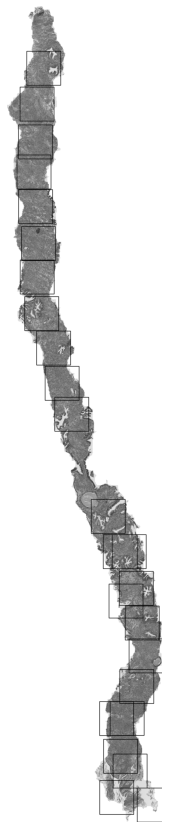

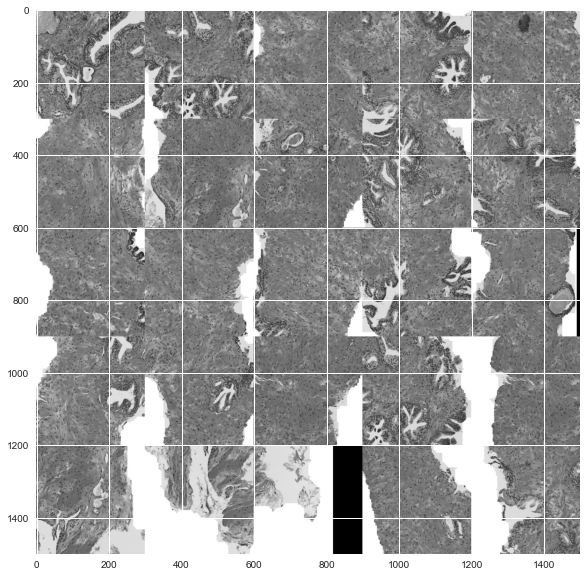

In [91]:
image = cv2.imread('cells/train1_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
# plt.imshow(image, cmap='gray')
plt.show()
res = cells(image, 300, 25, True)
plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')
plt.show()